In the prior GPT video, we tokenized on the level of characters; however, in practice, it is often at "chunk" level


A lot of the weirdness with LLMS is due to tokenization, i.e cant spell, cant process strings (ex. reverse str), worse at non-english languages, cant do basic math, trouble coding Python, will randomly stop after seeing "|endoftext| string, warnings about "trailing whitespace", will break if asked about "SolidGoldMagikarp", why it prefers the use of YAML over JSON, why it LLM is not actually end-to-end language modelling

Visualize Tokenization: https://tiktokenizer.vercel.app/

Ex.

Egg. = 2 tokens

I have an Egg; in this instance Egg. = 1 token for "space" Egg, wheras Egg by itself at start of sentence is 2 tokens

Main Point: For the same word, depeneding on where it is in sentence, if it is upper or lower case, all of these can have very different tokens. The Model needs to learn from the large corpus of internet, that these represent very similiar same concepts

For digit tokenization, can be arbitrary, where multiple digits can be represented by a single token, wherase single digits can require multiple tokens 

Tokenization is often much worse for non-english because the training sets used for tokenization are primarily english. Thus
for an english sentence with 10 words, might have 10 tokens; wheras for a korean translation, could require many more tokens 
as the chunks of the sentence are a lot more broken up. Using more tokens for the exact same thing, bloats up the sequence length for the documents, and in the attention of the transformer, when these tokens are trying to attend to each other, you
are running out of context in the maximum context length of that transformer

One of the problems with GPT2 and Python, is that each for each coding indent (as needed for Pyython), it would apply multiple "262" token ids (represents whitespace), and this ends up bloating out the text and it is seperated across way too much of the sequence and we are running out the context length in the sequence (taking up way too much token space)


When going from GPT2 to GPT4 tokenizer, a 300 token sequence, now equals around 180 token sequence, and this is because GPT4
uses more tokens (i.e has more tokens in vocab); provides a more denser input to Transformer (now can see twice as much text as a context for what token to predict next because of this change). However, making vocab just infinetely large is not a good idea since both the embedding table increases alongside the output Softmax dimension.

One important improvement in GPT4 tokenizer, is how they handled white space in Python code (requiring much fewer tokens as grouped alot of white space into single char), this allows for a more dense input to Transformer, allowing it to attend to more Code before it when trying to predict the next token in the seqeunece

Unicode: 150K characters (i.e symbols, emojis, letters etc...) and what integers represent those characters

In [1]:
#To access unicode code point 
ord("h")

104

In [3]:
ord("👋")

128075

In [4]:
ord("Hello")
#Will not work, as the function takes in a single character and returns its unicode code point

TypeError: ord() expected a character, but string of length 5 found

In [5]:
[ord(x) for x in "안녕하세요 👋 (hello in Korean!)"]

[50504,
 45397,
 54616,
 49464,
 50836,
 32,
 128075,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 75,
 111,
 114,
 101,
 97,
 110,
 33,
 41]

We dont use unicode code points for tokenization because a) large vocab(150K) and b) the unicode standard changes over time

Instead we use encodings (a way to take unicode text and translate it into binary data), EX. UTF-8 (will take a unicode code point and translate it a Byte Stream of 1 to 4 points)

In [7]:
"안녕하세요 👋 (hello in Korean!)".encode("utf-8")
#returns bytes object

b'\xec\x95\x88\xeb\x85\x95\xed\x95\x98\xec\x84\xb8\xec\x9a\x94 \xf0\x9f\x91\x8b (hello in Korean!)'

In [8]:
#Using list gives raw bytes representing input string
list("안녕하세요 👋 (hello in Korean!)".encode("utf-8"))

[236,
 149,
 136,
 235,
 133,
 149,
 237,
 149,
 152,
 236,
 132,
 184,
 236,
 154,
 148,
 32,
 240,
 159,
 145,
 139,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 75,
 111,
 114,
 101,
 97,
 110,
 33,
 41]

We cant use UTF-8 naively, because these are Byte Streams, and that would indicate a vocab length of 256 possible tokens. This is too small of a vocab size, which in turn would stretch out our text over very very long sequences of bytes, and in turn remembering we have a finite context length we can support in Transformer (due to computation reasons), and so will be unable to sufficiently attend to long sequence for next token prediction

We want to stick with UTF-8 encoding but allow for a tunable hyperparameter that can be used to generate larger vocab size

Thus, use Byte-Pair Encoding algo, which allows us to compress these Byte Sequences to a variable amount

In [236]:
list(("hi요").encode("utf-8")) #2 ints for 2 english chars, 3 ints for 1 non-english char

[104, 105, 236, 154, 148]

Byte-Pair Encoding Algo.

aaabcaaabac
11 tokens, vocab = 4
Find the pair of tokens which occur more often, and replace with a new Token which we append to vocab

ZabdZabac
Z=aa
9 tokens, vocab = 5

This process is repeated, Y= "ab"
ZYdZYac
7 tokens, vocab = 6

Repeat, find the pair ZY is common, X = ZY
XdXac
5 tokens, vocab = 7


In [13]:
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."
tokens = text.encode("utf-8")
tokens = list(map(int, tokens)) #Get list of raw bytes as integers
print("---")
print(text)
print("length:", len(text))
print("---")
print(tokens)
print("length:", len(tokens))


---
Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.
length: 533
---
[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140

In [17]:
#We have more tokens then text because alot of the complex unicode characters at the start of the sequence become multiple bytes (up to 4)
list("😄".encode("utf-8"))

[240, 159, 152, 132]

In [27]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1 #if not pair in counts.dict assign 0
    return counts

#Note: We consider all pair combinations, using a stride of 1

In [29]:
stats = get_stats(tokens)
print(sorted(((v,k) for k,v in stats.items()), reverse = True))

[(20, (101, 32)), (15, (240, 159)), (12, (226, 128)), (12, (105, 110)), (10, (115, 32)), (10, (97, 110)), (10, (32, 97)), (9, (32, 116)), (8, (116, 104)), (7, (159, 135)), (7, (159, 133)), (7, (97, 114)), (6, (239, 189)), (6, (140, 240)), (6, (128, 140)), (6, (116, 32)), (6, (114, 32)), (6, (111, 114)), (6, (110, 103)), (6, (110, 100)), (6, (109, 101)), (6, (104, 101)), (6, (101, 114)), (6, (32, 105)), (5, (117, 115)), (5, (115, 116)), (5, (110, 32)), (5, (100, 101)), (5, (44, 32)), (5, (32, 115)), (4, (116, 105)), (4, (116, 101)), (4, (115, 44)), (4, (114, 105)), (4, (111, 117)), (4, (111, 100)), (4, (110, 116)), (4, (110, 105)), (4, (105, 99)), (4, (104, 97)), (4, (103, 32)), (4, (101, 97)), (4, (100, 32)), (4, (99, 111)), (4, (97, 109)), (4, (85, 110)), (4, (32, 119)), (4, (32, 111)), (4, (32, 102)), (4, (32, 85)), (3, (118, 101)), (3, (116, 115)), (3, (116, 114)), (3, (116, 111)), (3, (114, 116)), (3, (114, 115)), (3, (114, 101)), (3, (111, 102)), (3, (111, 32)), (3, (108, 108)), (

In [34]:
chr(101), chr(32)
#Higlights alot of "e " in the text 

('e', ' ')

In [48]:
top_pair = max(stats, key = stats.get) #Max returns the maximum K, and we provide it a function stats.get which simply returns the V of the K
top_pair

(101, 32)

In [ ]:
#Now we will mint a new token (256) which replaces the most common pair (101,32)

In [79]:
# def merge(ids, most_common_pair, new_idx):
#     skip_flag = False
#     new_ids = []
#     for idx in range(len(ids)):
#         if skip_flag == True: #This is needed to ensure that when we replace the most common pair (101,32); 101 corresponds to idx = 0 with (256), in the next iteration we dont add back 32 to new_idx as idx = 0 would now correspond to it
#             skip_flag = False
#             continue
#         if idx == len(ids) - 1:
#             new_ids.append(ids[idx])
#             continue
#         pair = (ids[idx], ids[idx+1])
#         if pair == most_common_pair:
#             new_ids.append(new_idx)
#             skip_flag = True
#         else:
#             new_ids.append(ids[idx])
#     return new_ids 

"KARPATHY Implementation; both work"
def merge(ids, pair, idx):
  # in the list of ints (ids), replace all consecutive occurences of pair with the new token idx
  newids = []
  i = 0
  while i < len(ids):
    # if we are not at the very last position AND the pair matches, replace it
    if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
      newids.append(idx)
      i += 2
    else:
      newids.append(ids[i])
      i += 1
  return newids

In [73]:
print(merge([5,6,6,7,9,1], (6,7), 99))

[5, 6, 99, 9, 1]


In [75]:
tokens2 = merge(tokens, top_pair, 256)

In [76]:
len(tokens2)

596

In [77]:
len(tokens) - len(tokens2)

20

In [80]:
# making the training text longer to have more representative token statistics
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = """A Programmer’s Introduction to Unicode March 3, 2017 · Coding · 22 Comments  Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺\u200c🇳\u200c🇮\u200c🇨\u200c🇴\u200c🇩\u200c🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.  A few months ago, I got interested in Unicode and decided to spend some time learning more about it in detail. In this article, I’ll give an introduction to it from a programmer’s point of view.  I’m going to focus on the character set and what’s involved in working with strings and files of Unicode text. However, in this article I’m not going to talk about fonts, text layout/shaping/rendering, or localization in detail—those are separate issues, beyond my scope (and knowledge) here.  Diversity and Inherent Complexity The Unicode Codespace Codespace Allocation Scripts Usage Frequency Encodings UTF-8 UTF-16 Combining Marks Canonical Equivalence Normalization Forms Grapheme Clusters And More… Diversity and Inherent Complexity As soon as you start to study Unicode, it becomes clear that it represents a large jump in complexity over character sets like ASCII that you may be more familiar with. It’s not just that Unicode contains a much larger number of characters, although that’s part of it. Unicode also has a great deal of internal structure, features, and special cases, making it much more than what one might expect a mere “character set” to be. We’ll see some of that later in this article.  When confronting all this complexity, especially as an engineer, it’s hard not to find oneself asking, “Why do we need all this? Is this really necessary? Couldn’t it be simplified?”  However, Unicode aims to faithfully represent the entire world’s writing systems. The Unicode Consortium’s stated goal is “enabling people around the world to use computers in any language”. And as you might imagine, the diversity of written languages is immense! To date, Unicode supports 135 different scripts, covering some 1100 languages, and there’s still a long tail of over 100 unsupported scripts, both modern and historical, which people are still working to add.  Given this enormous diversity, it’s inevitable that representing it is a complicated project. Unicode embraces that diversity, and accepts the complexity inherent in its mission to include all human writing systems. It doesn’t make a lot of trade-offs in the name of simplification, and it makes exceptions to its own rules where necessary to further its mission.  Moreover, Unicode is committed not just to supporting texts in any single language, but also to letting multiple languages coexist within one text—which introduces even more complexity.  Most programming languages have libraries available to handle the gory low-level details of text manipulation, but as a programmer, you’ll still need to know about certain Unicode features in order to know when and how to apply them. It may take some time to wrap your head around it all, but don’t be discouraged—think about the billions of people for whom your software will be more accessible through supporting text in their language. Embrace the complexity!  The Unicode Codespace Let’s start with some general orientation. The basic elements of Unicode—its “characters”, although that term isn’t quite right—are called code points. Code points are identified by number, customarily written in hexadecimal with the prefix “U+”, such as U+0041 “A” latin capital letter a or U+03B8 “θ” greek small letter theta. Each code point also has a short name, and quite a few other properties, specified in the Unicode Character Database.  The set of all possible code points is called the codespace. The Unicode codespace consists of 1,114,112 code points. However, only 128,237 of them—about 12% of the codespace—are actually assigned, to date. There’s plenty of room for growth! Unicode also reserves an additional 137,468 code points as “private use” areas, which have no standardized meaning and are available for individual applications to define for their own purposes.  Codespace Allocation To get a feel for how the codespace is laid out, it’s helpful to visualize it. Below is a map of the entire codespace, with one pixel per code point. It’s arranged in tiles for visual coherence; each small square is 16×16 = 256 code points, and each large square is a “plane” of 65,536 code points. There are 17 planes altogether.  Map of the Unicode codespace (click to zoom)  White represents unassigned space. Blue is assigned code points, green is private-use areas, and the small red area is surrogates (more about those later). As you can see, the assigned code points are distributed somewhat sparsely, but concentrated in the first three planes.  Plane 0 is also known as the “Basic Multilingual Plane”, or BMP. The BMP contains essentially all the characters needed for modern text in any script, including Latin, Cyrillic, Greek, Han (Chinese), Japanese, Korean, Arabic, Hebrew, Devanagari (Indian), and many more.  (In the past, the codespace was just the BMP and no more—Unicode was originally conceived as a straightforward 16-bit encoding, with only 65,536 code points. It was expanded to its current size in 1996. However, the vast majority of code points in modern text belong to the BMP.)  Plane 1 contains historical scripts, such as Sumerian cuneiform and Egyptian hieroglyphs, as well as emoji and various other symbols. Plane 2 contains a large block of less-common and historical Han characters. The remaining planes are empty, except for a small number of rarely-used formatting characters in Plane 14; planes 15–16 are reserved entirely for private use.  Scripts Let’s zoom in on the first three planes, since that’s where the action is:  Map of scripts in Unicode planes 0–2 (click to zoom)  This map color-codes the 135 different scripts in Unicode. You can see how Han () and Korean () take up most of the range of the BMP (the left large square). By contrast, all of the European, Middle Eastern, and South Asian scripts fit into the first row of the BMP in this diagram.  Many areas of the codespace are adapted or copied from earlier encodings. For example, the first 128 code points of Unicode are just a copy of ASCII. This has clear benefits for compatibility—it’s easy to losslessly convert texts from smaller encodings into Unicode (and the other direction too, as long as no characters outside the smaller encoding are used).  Usage Frequency One more interesting way to visualize the codespace is to look at the distribution of usage—in other words, how often each code point is actually used in real-world texts. Below is a heat map of planes 0–2 based on a large sample of text from Wikipedia and Twitter (all languages). Frequency increases from black (never seen) through red and yellow to white.  Heat map of code point usage frequency in Unicode planes 0–2 (click to zoom)  You can see that the vast majority of this text sample lies in the BMP, with only scattered usage of code points from planes 1–2. The biggest exception is emoji, which show up here as the several bright squares in the bottom row of plane 1.  Encodings We’ve seen that Unicode code points are abstractly identified by their index in the codespace, ranging from U+0000 to U+10FFFF. But how do code points get represented as bytes, in memory or in a file?  The most convenient, computer-friendliest (and programmer-friendliest) thing to do would be to just store the code point index as a 32-bit integer. This works, but it consumes 4 bytes per code point, which is sort of a lot. Using 32-bit ints for Unicode will cost you a bunch of extra storage, memory, and performance in bandwidth-bound scenarios, if you work with a lot of text.  Consequently, there are several more-compact encodings for Unicode. The 32-bit integer encoding is officially called UTF-32 (UTF = “Unicode Transformation Format”), but it’s rarely used for storage. At most, it comes up sometimes as a temporary internal representation, for examining or operating on the code points in a string.  Much more commonly, you’ll see Unicode text encoded as either UTF-8 or UTF-16. These are both variable-length encodings, made up of 8-bit or 16-bit units, respectively. In these schemes, code points with smaller index values take up fewer bytes, which saves a lot of memory for typical texts. The trade-off is that processing UTF-8/16 texts is more programmatically involved, and likely slower.  UTF-8 In UTF-8, each code point is stored using 1 to 4 bytes, based on its index value.  UTF-8 uses a system of binary prefixes, in which the high bits of each byte mark whether it’s a single byte, the beginning of a multi-byte sequence, or a continuation byte; the remaining bits, concatenated, give the code point index. This table shows how it works:  UTF-8 (binary)\tCode point (binary)\tRange 0xxxxxxx\txxxxxxx\tU+0000–U+007F 110xxxxx 10yyyyyy\txxxxxyyyyyy\tU+0080–U+07FF 1110xxxx 10yyyyyy 10zzzzzz\txxxxyyyyyyzzzzzz\tU+0800–U+FFFF 11110xxx 10yyyyyy 10zzzzzz 10wwwwww\txxxyyyyyyzzzzzzwwwwww\tU+10000–U+10FFFF A handy property of UTF-8 is that code points below 128 (ASCII characters) are encoded as single bytes, and all non-ASCII code points are encoded using sequences of bytes 128–255. This has a couple of nice consequences. First, any strings or files out there that are already in ASCII can also be interpreted as UTF-8 without any conversion. Second, lots of widely-used string programming idioms—such as null termination, or delimiters (newlines, tabs, commas, slashes, etc.)—will just work on UTF-8 strings. ASCII bytes never occur inside the encoding of non-ASCII code points, so searching byte-wise for a null terminator or a delimiter will do the right thing.  Thanks to this convenience, it’s relatively simple to extend legacy ASCII programs and APIs to handle UTF-8 strings. UTF-8 is very widely used in the Unix/Linux and Web worlds, and many programmers argue UTF-8 should be the default encoding everywhere.  However, UTF-8 isn’t a drop-in replacement for ASCII strings in all respects. For instance, code that iterates over the “characters” in a string will need to decode UTF-8 and iterate over code points (or maybe grapheme clusters—more about those later), not bytes. When you measure the “length” of a string, you’ll need to think about whether you want the length in bytes, the length in code points, the width of the text when rendered, or something else.  UTF-16 The other encoding that you’re likely to encounter is UTF-16. It uses 16-bit words, with each code point stored as either 1 or 2 words.  Like UTF-8, we can express the UTF-16 encoding rules in the form of binary prefixes:  UTF-16 (binary)\tCode point (binary)\tRange xxxxxxxxxxxxxxxx\txxxxxxxxxxxxxxxx\tU+0000–U+FFFF 110110xxxxxxxxxx 110111yyyyyyyyyy\txxxxxxxxxxyyyyyyyyyy + 0x10000\tU+10000–U+10FFFF A more common way that people talk about UTF-16 encoding, though, is in terms of code points called “surrogates”. All the code points in the range U+D800–U+DFFF—or in other words, the code points that match the binary prefixes 110110 and 110111 in the table above—are reserved specifically for UTF-16 encoding, and don’t represent any valid characters on their own. They’re only meant to occur in the 2-word encoding pattern above, which is called a “surrogate pair”. Surrogate code points are illegal in any other context! They’re not allowed in UTF-8 or UTF-32 at all.  Historically, UTF-16 is a descendant of the original, pre-1996 versions of Unicode, in which there were only 65,536 code points. The original intention was that there would be no different “encodings”; Unicode was supposed to be a straightforward 16-bit character set. Later, the codespace was expanded to make room for a long tail of less-common (but still important) Han characters, which the Unicode designers didn’t originally plan for. Surrogates were then introduced, as—to put it bluntly—a kludge, allowing 16-bit encodings to access the new code points.  Today, Javascript uses UTF-16 as its standard string representation: if you ask for the length of a string, or iterate over it, etc., the result will be in UTF-16 words, with any code points outside the BMP expressed as surrogate pairs. UTF-16 is also used by the Microsoft Win32 APIs; though Win32 supports either 8-bit or 16-bit strings, the 8-bit version unaccountably still doesn’t support UTF-8—only legacy code-page encodings, like ANSI. This leaves UTF-16 as the only way to get proper Unicode support in Windows. (Update: in Win10 version 1903, they finally added UTF-8 support to the 8-bit APIs! 😊)  By the way, UTF-16’s words can be stored either little-endian or big-endian. Unicode has no opinion on that issue, though it does encourage the convention of putting U+FEFF zero width no-break space at the top of a UTF-16 file as a byte-order mark, to disambiguate the endianness. (If the file doesn’t match the system’s endianness, the BOM will be decoded as U+FFFE, which isn’t a valid code point.)  Combining Marks In the story so far, we’ve been focusing on code points. But in Unicode, a “character” can be more complicated than just an individual code point!  Unicode includes a system for dynamically composing characters, by combining multiple code points together. This is used in various ways to gain flexibility without causing a huge combinatorial explosion in the number of code points.  In European languages, for example, this shows up in the application of diacritics to letters. Unicode supports a wide range of diacritics, including acute and grave accents, umlauts, cedillas, and many more. All these diacritics can be applied to any letter of any alphabet—and in fact, multiple diacritics can be used on a single letter.  If Unicode tried to assign a distinct code point to every possible combination of letter and diacritics, things would rapidly get out of hand. Instead, the dynamic composition system enables you to construct the character you want, by starting with a base code point (the letter) and appending additional code points, called “combining marks”, to specify the diacritics. When a text renderer sees a sequence like this in a string, it automatically stacks the diacritics over or under the base letter to create a composed character.  For example, the accented character “Á” can be expressed as a string of two code points: U+0041 “A” latin capital letter a plus U+0301 “◌́” combining acute accent. This string automatically gets rendered as a single character: “Á”.  Now, Unicode does also include many “precomposed” code points, each representing a letter with some combination of diacritics already applied, such as U+00C1 “Á” latin capital letter a with acute or U+1EC7 “ệ” latin small letter e with circumflex and dot below. I suspect these are mostly inherited from older encodings that were assimilated into Unicode, and kept around for compatibility. In practice, there are precomposed code points for most of the common letter-with-diacritic combinations in European-script languages, so they don’t use dynamic composition that much in typical text.  Still, the system of combining marks does allow for an arbitrary number of diacritics to be stacked on any base character. The reductio-ad-absurdum of this is Zalgo text, which works by ͖͟ͅr͞aṋ̫̠̖͈̗d͖̻̹óm̪͙͕̗̝ļ͇̰͓̳̫ý͓̥̟͍ ̕s̫t̫̱͕̗̰̼̘͜a̼̩͖͇̠͈̣͝c̙͍k̖̱̹͍͘i̢n̨̺̝͇͇̟͙ģ̫̮͎̻̟ͅ ̕n̼̺͈͞u̮͙m̺̭̟̗͞e̞͓̰̤͓̫r̵o̖ṷs҉̪͍̭̬̝̤ ̮͉̝̞̗̟͠d̴̟̜̱͕͚i͇̫̼̯̭̜͡ḁ͙̻̼c̲̲̹r̨̠̹̣̰̦i̱t̤̻̤͍͙̘̕i̵̜̭̤̱͎c̵s ͘o̱̲͈̙͖͇̲͢n͘ ̜͈e̬̲̠̩ac͕̺̠͉h̷̪ ̺̣͖̱ḻ̫̬̝̹ḙ̙̺͙̭͓̲t̞̞͇̲͉͍t̷͔̪͉̲̻̠͙e̦̻͈͉͇r͇̭̭̬͖,̖́ ̜͙͓̣̭s̘̘͈o̱̰̤̲ͅ ̛̬̜̙t̼̦͕̱̹͕̥h̳̲͈͝ͅa̦t̻̲ ̻̟̭̦̖t̛̰̩h̠͕̳̝̫͕e͈̤̘͖̞͘y҉̝͙ ̷͉͔̰̠o̞̰v͈͈̳̘͜er̶f̰͈͔ḻ͕̘̫̺̲o̲̭͙͠ͅw̱̳̺ ͜t̸h͇̭͕̳͍e̖̯̟̠ ͍̞̜͔̩̪͜ļ͎̪̲͚i̝̲̹̙̩̹n̨̦̩̖ḙ̼̲̼͢ͅ ̬͝s̼͚̘̞͝p͙̘̻a̙c҉͉̜̤͈̯̖i̥͡n̦̠̱͟g̸̗̻̦̭̮̟ͅ ̳̪̠͖̳̯̕a̫͜n͝d͡ ̣̦̙ͅc̪̗r̴͙̮̦̹̳e͇͚̞͔̹̫͟a̙̺̙ț͔͎̘̹ͅe̥̩͍ a͖̪̜̮͙̹n̢͉̝ ͇͉͓̦̼́a̳͖̪̤̱p̖͔͔̟͇͎͠p̱͍̺ę̲͎͈̰̲̤̫a̯͜r̨̮̫̣̘a̩̯͖n̹̦̰͎̣̞̞c̨̦̱͔͎͍͖e̬͓͘ ̤̰̩͙̤̬͙o̵̼̻̬̻͇̮̪f̴ ̡̙̭͓͖̪̤“̸͙̠̼c̳̗͜o͏̼͙͔̮r̞̫̺̞̥̬ru̺̻̯͉̭̻̯p̰̥͓̣̫̙̤͢t̳͍̳̖ͅi̶͈̝͙̼̙̹o̡͔n̙̺̹̖̩͝ͅ”̨̗͖͚̩.̯͓  A few other places where dynamic character composition shows up in Unicode:  Vowel-pointing notation in Arabic and Hebrew. In these languages, words are normally spelled with some of their vowels left out. They then have diacritic notation to indicate the vowels (used in dictionaries, language-teaching materials, children’s books, and such). These diacritics are expressed with combining marks.  A Hebrew example, with niqqud:\tאֶת דַלְתִּי הֵזִיז הֵנִיעַ, קֶטֶב לִשְׁכַּתִּי יָשׁוֹד Normal writing (no niqqud):\tאת דלתי הזיז הניע, קטב לשכתי ישוד Devanagari, the script used to write Hindi, Sanskrit, and many other South Asian languages, expresses certain vowels as combining marks attached to consonant letters. For example, “ह” + “\u200bि” = “हि” (“h” + “i” = “hi”). Korean characters stand for syllables, but they are composed of letters called jamo that stand for the vowels and consonants in the syllable. While there are code points for precomposed Korean syllables, it’s also possible to dynamically compose them by concatenating their jamo. For example, “ᄒ” + “ᅡ” + “ᆫ” = “한” (“h” + “a” + “n” = “han”). Canonical Equivalence In Unicode, precomposed characters exist alongside the dynamic composition system. A consequence of this is that there are multiple ways to express “the same” string—different sequences of code points that result in the same user-perceived characters. For example, as we saw earlier, we can express the character “Á” either as the single code point U+00C1, or as the string of two code points U+0041 U+0301.  Another source of ambiguity is the ordering of multiple diacritics in a single character. Diacritic order matters visually when two diacritics apply to the same side of the base character, e.g. both above: “ǡ” (dot, then macron) is different from “ā̇” (macron, then dot). However, when diacritics apply to different sides of the character, e.g. one above and one below, then the order doesn’t affect rendering. Moreover, a character with multiple diacritics might have one of the diacritics precomposed and others expressed as combining marks.  For example, the Vietnamese letter “ệ” can be expressed in five different ways:  Fully precomposed: U+1EC7 “ệ” Partially precomposed: U+1EB9 “ẹ” + U+0302 “◌̂” Partially precomposed: U+00EA “ê” + U+0323 “◌̣” Fully decomposed: U+0065 “e” + U+0323 “◌̣” + U+0302 “◌̂” Fully decomposed: U+0065 “e” + U+0302 “◌̂” + U+0323 “◌̣” Unicode refers to set of strings like this as “canonically equivalent”. Canonically equivalent strings are supposed to be treated as identical for purposes of searching, sorting, rendering, text selection, and so on. This has implications for how you implement operations on text. For example, if an app has a “find in file” operation and the user searches for “ệ”, it should, by default, find occurrences of any of the five versions of “ệ” above!  Normalization Forms To address the problem of “how to handle canonically equivalent strings”, Unicode defines several normalization forms: ways of converting strings into a canonical form so that they can be compared code-point-by-code-point (or byte-by-byte).  The “NFD” normalization form fully decomposes every character down to its component base and combining marks, taking apart any precomposed code points in the string. It also sorts the combining marks in each character according to their rendered position, so e.g. diacritics that go below the character come before the ones that go above the character. (It doesn’t reorder diacritics in the same rendered position, since their order matters visually, as previously mentioned.)  The “NFC” form, conversely, puts things back together into precomposed code points as much as possible. If an unusual combination of diacritics is called for, there may not be any precomposed code point for it, in which case NFC still precomposes what it can and leaves any remaining combining marks in place (again ordered by rendered position, as in NFD).  There are also forms called NFKD and NFKC. The “K” here refers to compatibility decompositions, which cover characters that are “similar” in some sense but not visually identical. However, I’m not going to cover that here.  Grapheme Clusters As we’ve seen, Unicode contains various cases where a thing that a user thinks of as a single “character” might actually be made up of multiple code points under the hood. Unicode formalizes this using the notion of a grapheme cluster: a string of one or more code points that constitute a single “user-perceived character”.  UAX #29 defines the rules for what, precisely, qualifies as a grapheme cluster. It’s approximately “a base code point followed by any number of combining marks”, but the actual definition is a bit more complicated; it accounts for things like Korean jamo, and emoji ZWJ sequences.  The main thing grapheme clusters are used for is text editing: they’re often the most sensible unit for cursor placement and text selection boundaries. Using grapheme clusters for these purposes ensures that you can’t accidentally chop off some diacritics when you copy-and-paste text, that left/right arrow keys always move the cursor by one visible character, and so on.  Another place where grapheme clusters are useful is in enforcing a string length limit—say, on a database field. While the true, underlying limit might be something like the byte length of the string in UTF-8, you wouldn’t want to enforce that by just truncating bytes. At a minimum, you’d want to “round down” to the nearest code point boundary; but even better, round down to the nearest grapheme cluster boundary. Otherwise, you might be corrupting the last character by cutting off a diacritic, or interrupting a jamo sequence or ZWJ sequence.  And More… There’s much more that could be said about Unicode from a programmer’s perspective! I haven’t gotten into such fun topics as case mapping, collation, compatibility decompositions and confusables, Unicode-aware regexes, or bidirectional text. Nor have I said anything yet about implementation issues—how to efficiently store and look-up data about the sparsely-assigned code points, or how to optimize UTF-8 decoding, string comparison, or NFC normalization. Perhaps I’ll return to some of those things in future posts.  Unicode is a fascinating and complex system. It has a many-to-one mapping between bytes and code points, and on top of that a many-to-one (or, under some circumstances, many-to-many) mapping between code points and “characters”. It has oddball special cases in every corner. But no one ever claimed that representing all written languages was going to be easy, and it’s clear that we’re never going back to the bad old days of a patchwork of incompatible encodings.  Further reading:  The Unicode Standard UTF-8 Everywhere Manifesto Dark corners of Unicode by Eevee ICU (International Components for Unicode)—C/C++/Java libraries implementing many Unicode algorithms and related things Python 3 Unicode Howto Google Noto Fonts—set of fonts intended to cover all assigned code points"""
tokens = text.encode("utf-8") # raw bytes
tokens = list(map(int, tokens)) # convert to a list of integers in range 0..255 for convenience

In [81]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1 
    return counts

def merge(ids, pair, idx):
  newids = []
  i = 0
  while i < len(ids):
    if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
      newids.append(idx)
      i += 2
    else:
      newids.append(ids[i])
      i += 1
  return newids
# ---
vocab_size = 276 #The desired final vocab size; it is a hyperparameter
num_merges = vocab_size - 256 #Their are by default 256 chars, so 276 - 256 tells us how many loops to do for minting new tokens
ids = list(tokens) #creates a copy of list

merges = {} # (int, int) -> int
for i in range(num_merges):
   stats = get_stats(ids)
   top_pair = max(stats, key = stats.get)
   idx = 256 + i
   print(f"merging {top_pair} into a new token {idx}")
   ids = merge(ids, top_pair, idx)
   merges[top_pair] = idx

merging (101, 32) into a new token 256
merging (105, 110) into a new token 257
merging (115, 32) into a new token 258
merging (116, 104) into a new token 259
merging (101, 114) into a new token 260
merging (99, 111) into a new token 261
merging (116, 32) into a new token 262
merging (226, 128) into a new token 263
merging (44, 32) into a new token 264
merging (97, 110) into a new token 265
merging (111, 114) into a new token 266
merging (100, 32) into a new token 267
merging (97, 114) into a new token 268
merging (101, 110) into a new token 269
merging (257, 103) into a new token 270
merging (261, 100) into a new token 271
merging (121, 32) into a new token 272
merging (46, 32) into a new token 273
merging (97, 108) into a new token 274
merging (259, 256) into a new token 275


In [82]:
#Getting compression statistics of original sequence and new sequence with expanded vocab
print("tokens length:", len(tokens))
print("ids length", len(ids))
print(f"compression ratio: {len(tokens) / len(ids):.2f}X")

tokens length: 24597
ids length 19438
compression ratio: 1.27


Note: The Tokenizer is a completely seperate, independent module from the LLM. It has its own training dataset of text (which could be different from that of the LLM), on which you train the vocabulary using the Byte Pair Encoding (BPE) algo. It can then be used for encoding and decoding purposes

When training the tokenizer, we dont only care about english, we could care about japanese or code vs. not code; and so it would be useful to look into different mixtures of different kinds of languages/code. This variety will determine how many merges of it there will be and that determines the type of density that type of data has in the token space. I.E more Japanese data during training, will have more Japanese tokens merged, and so Japanese will have shorter sequences, which will benefit the LLM which has a finite context length it can work on the token space

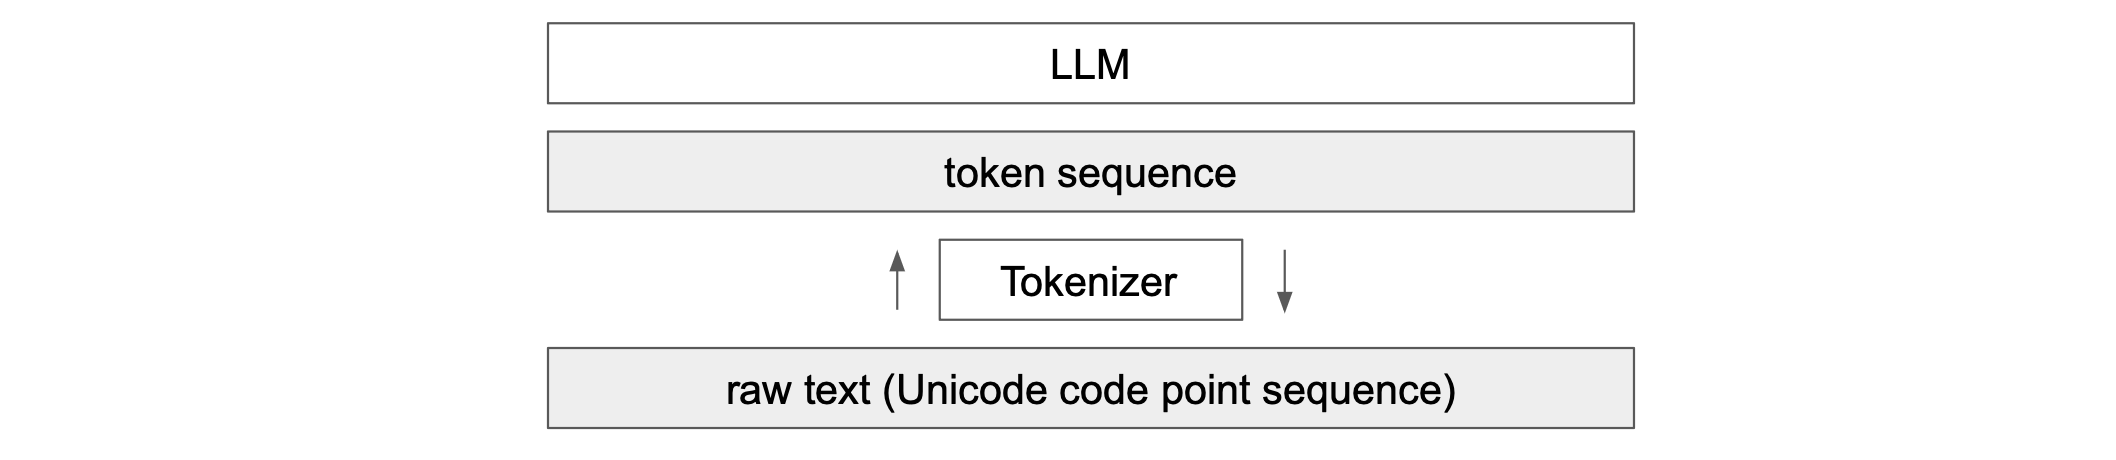

In [162]:
#Recursion based approach
def my_decode(ids):
    #given ids (list of integers), return Python string
    vocab = {idx: bytes([idx]) for idx in range(256)}
    for  k,v in merges.items():
        vocab[v] = k

    def decoder(id):
        if not(id in merges.values()):
            return vocab[id]
        else:
            t1, t2 = vocab[id]
            return decoder(t1) + decoder(t2)
        
    decoded = b"".join([decoder(id) for id in ids])
    decoded = decoded.decode("utf-8", errors="replace")
    return decoded
        

In [163]:
my_decode(ids)

'A Programmer’s Introduction to Unicode March 3, 2017 · Coding · 22 Comments  Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺\u200c🇳\u200c🇮\u200c🇨\u200c🇴\u200c🇩\u200c🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.  A few months ago, I got interested in Unicode and decided to spend some time learning more about it in detail. In this article, I’ll give an introduction to it from a programmer’s point of view.  I’m going to focus on the character set and what’s involved in working with strings and files of Unicode text. However, in this article I’m not going to talk abo

In [164]:
vocab = {idx: bytes([idx]) for idx in range(256)} #mapping from token id to the  bytes object of the token
for (p0, p1), idx in merges.items(): #go in order of all the merges (IMPORTANT: in Python 3.7 will go in order of in which items were inserted into the merges dict ), this order is important because EX. custom token 258 = token 3 + custom token 257, where custom token 257 = token 4 + token 6; so need to define componenets of token 257 to then define token 258
    vocab[idx] = vocab[p0] + vocab[p1]   #populate the vocab list with concatenation of the bytes objects

def decode(ids):
  # given ids (list of integers), return Python string
  tokens = b"".join(vocab[idx] for idx in ids) #b"" concatenates bytes
  text = tokens.decode("utf-8", errors="replace") #raw bytes are decoded
  return text

print(decode(ids))

A Programmer’s Introduction to Unicode March 3, 2017 · Coding · 22 Comments  Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.  A few months ago, I got interested in Unicode and decided to spend some time learning more about it in detail. In this article, I’ll give an introduction to it from a programmer’s point of view.  I’m going to focus on the character set and what’s involved in working with strings and files of Unicode text. However, in this article I’m not going to talk about fonts, text layout/shaping/r

In [209]:
vocab

{0: b'\x00',
 1: b'\x01',
 2: b'\x02',
 3: b'\x03',
 4: b'\x04',
 5: b'\x05',
 6: b'\x06',
 7: b'\x07',
 8: b'\x08',
 9: b'\t',
 10: b'\n',
 11: b'\x0b',
 12: b'\x0c',
 13: b'\r',
 14: b'\x0e',
 15: b'\x0f',
 16: b'\x10',
 17: b'\x11',
 18: b'\x12',
 19: b'\x13',
 20: b'\x14',
 21: b'\x15',
 22: b'\x16',
 23: b'\x17',
 24: b'\x18',
 25: b'\x19',
 26: b'\x1a',
 27: b'\x1b',
 28: b'\x1c',
 29: b'\x1d',
 30: b'\x1e',
 31: b'\x1f',
 32: b' ',
 33: b'!',
 34: b'"',
 35: b'#',
 36: b'$',
 37: b'%',
 38: b'&',
 39: b"'",
 40: b'(',
 41: b')',
 42: b'*',
 43: b'+',
 44: b',',
 45: b'-',
 46: b'.',
 47: b'/',
 48: b'0',
 49: b'1',
 50: b'2',
 51: b'3',
 52: b'4',
 53: b'5',
 54: b'6',
 55: b'7',
 56: b'8',
 57: b'9',
 58: b':',
 59: b';',
 60: b'<',
 61: b'=',
 62: b'>',
 63: b'?',
 64: b'@',
 65: b'A',
 66: b'B',
 67: b'C',
 68: b'D',
 69: b'E',
 70: b'F',
 71: b'G',
 72: b'H',
 73: b'I',
 74: b'J',
 75: b'K',
 76: b'L',
 77: b'M',
 78: b'N',
 79: b'O',
 80: b'P',
 81: b'Q',
 82: b'R',
 83: b'

In [165]:
my_decode(ids) == decode(ids)

True

In [184]:
def my_encode(text):
    #given a string, return a list of integers (the tokens)
    text = list(text.encode("utf-8"))
    changes = True
    while changes == True:
        changes = False
        tokens = []
        idx = 0
        while idx < len(text):
            if idx < len(text) - 1 and (text[idx],text[idx+1]) in merges.keys():
                tokens.append(merges[(text[idx],text[idx+1])])
                changes = True
                idx +=2
            else:
                tokens.append(text[idx])
                idx +=1
        text = tokens
    return text

print(my_encode("hello world!"))

[104, 101, 108, 108, 111, 32, 119, 266, 108, 100, 33]


In [179]:
print(decode(my_encode("hello world!")))

hello world!


In [175]:
stats

{(65, 32): 8,
 (32, 80): 7,
 (80, 114): 1,
 (114, 111): 57,
 (111, 103): 23,
 (103, 114): 25,
 (114, 97): 40,
 (97, 109): 47,
 (109, 109): 20,
 (109, 260): 10,
 (260, 263): 6,
 (263, 153): 64,
 (153, 258): 29,
 (258, 73): 3,
 (73, 110): 15,
 (110, 116): 18,
 (116, 114): 50,
 (111, 100): 18,
 (100, 117): 8,
 (117, 99): 19,
 (99, 116): 62,
 (116, 105): 134,
 (105, 111): 76,
 (111, 110): 143,
 (110, 32): 78,
 (32, 116): 66,
 (116, 111): 110,
 (111, 32): 137,
 (32, 85): 66,
 (85, 110): 60,
 (110, 105): 71,
 (105, 271): 59,
 (271, 256): 111,
 (256, 77): 3,
 (77, 268): 3,
 (268, 99): 4,
 (99, 104): 89,
 (104, 32): 45,
 (32, 51): 5,
 (51, 264): 2,
 (264, 50): 1,
 (50, 48): 1,
 (48, 49): 7,
 (49, 55): 2,
 (55, 32): 5,
 (32, 194): 2,
 (194, 183): 2,
 (183, 32): 2,
 (32, 67): 8,
 (67, 111): 17,
 (100, 270): 7,
 (270, 32): 107,
 (32, 50): 3,
 (50, 50): 1,
 (50, 32): 14,
 (111, 109): 43,
 (109, 269): 10,
 (269, 116): 36,
 (116, 258): 68,
 (258, 32): 1,
 (32, 239): 1,
 (239, 188): 1,
 (188, 181): 1

In [176]:
merges

{(101, 32): 256,
 (105, 110): 257,
 (115, 32): 258,
 (116, 104): 259,
 (101, 114): 260,
 (99, 111): 261,
 (116, 32): 262,
 (226, 128): 263,
 (44, 32): 264,
 (97, 110): 265,
 (111, 114): 266,
 (100, 32): 267,
 (97, 114): 268,
 (101, 110): 269,
 (257, 103): 270,
 (261, 100): 271,
 (121, 32): 272,
 (46, 32): 273,
 (97, 108): 274,
 (259, 256): 275}

In [177]:
def encode(text):
  # given a string, return list of integers (the tokens)
  tokens = list(text.encode("utf-8"))
  while len(tokens) >= 2: #fixes bug with min, when one token in sequence
    stats = get_stats(tokens) #Will be getting all the possible byte pairs, dont care about number of times they appear
    #We moreso care about finding the byte pair which was added earliest to the merges dict; since remember later custom byte pairs can be a combination of earlier custom tokens/bytes; so need to derive the token representations of early byte pairs to progressively convert the sequence
    pair = min(stats, key=lambda p: merges.get(p, float("inf"))) #Similiar to Max, Min will iterate over the keys in the dict STATS. In order to sort the keys, need to define a function, 
    #in this case using merges.get, which will return the int index we used for byte pairs. Byte pairs which were added earlier have a lower int index. "inf" is used to assign values for pairs in STATS that do not appear in merges
    if pair not in merges:
      break # nothing else can be merged
    #if we find a pair which can be merged/inside merges, then use the prior merge function
    idx = merges[pair]
    tokens = merge(tokens, pair, idx)
  return tokens

print(encode("hello world!"))

[104, 101, 108, 108, 111, 32, 119, 266, 108, 100, 33]


In [185]:
print(decode(encode("hello world")))

hello world


In [189]:
text2 = decode(encode(text))
print(text2 == text)
#Checking after encoding and decoding, get the same thing back w.r.t to tokenizer training

True


In [190]:
#Also testing out validation data (data not used to build/seen by tokenizer)
valtext = "Many common characters, including numerals, punctuation, and other symbols, are unified within the standard and are not treated as specific to any given writing system. Unicode encodes thousands of emoji, with the continued development thereof conducted by the Consortium as a part of the standard.[4] Moreover, the widespread adoption of Unicode was in large part responsible for the initial popularization of emoji outside of Japan. Unicode is ultimately capable of encoding more than 1.1 million characters."
valtext2 = decode(encode(valtext))
print(valtext2 == valtext)

True


In [ ]:
#The "parameters" of the Byte Pair Encoding tokenizer are really the dictionary of merges

The above is the basics of the Byte Pair Encoding Tokenizer, however current approaches to tokenization for LLMs have expanded upon this with additional complexity 

Let's look at the GPT series

One issues the GPT team recognized, is that common words like DOG, might appear frequently with punctutation such as DOG!, DOG., DOG? and naively the BP algo could merge these, ending up with a lot of DOG tokens with slightly different punctuation. So feels like you are clustering things that shouldnt be clustered (i.e semantics and punctuation); which is suboptimal. So the team wanted to enforce that some characters should never be merged together 

Forced splits using regex patterns (GPT series)

In [196]:
import regex as re
gpt2pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")

print(re.findall(gpt2pat, "Hello world how are you")) #finds all the occurances of the "gpt2pat" pattern in an arbitrary string (going from left to right) and places in list
#Looking at "Hello" (really starting at  "H"), we can see it is not 's, 't etc... but it is " ?\p{L}+""; where " ?\p{L}+" refers to optional space + any letters and HELLO is made up of letters
#But the match ends, since the white space between HELLO WORLD is not a letter. Now a new attempt starts to match " world", where once again " ?\p{N}+" will work where " WORLD" has a starting space = optional space + a bunch of letters
#So we get a set of elements...

['Hello', ' world', ' how', ' are', ' you']


Once these list of elements/texts are created from an input text, all these elements are processed independently by the tokenizer into a token sequence and all the results of this processing are concatenated

Thus will only find merges with each elements of the list individually, I.E only consider merges in "Hello". After you have done all the possible merging for these elements individually, the results of all that will be joined by concatenation

So, for instance will never merge the e in are with a space in " you" as these are now seperate elements in the list

So this REGEX pattern, is one approach used to enforce that certain merges will not happen

At high level, the above pattern is used to mitigate merging across letters, across numbers, across punctuation etc...

In [204]:
import regex as re
gpt2pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")
#" ?\p{N}+" similiar to the p{L} but instead numbers
#'ve looks for exactly 've
#Can see tokenization inconsistent in upper case HOW'S
#  ?[^\s\p{L}\p{N}]+ -> optional space followed by somthing that is not a space,letter,number and can have 1 or more of that; roughly speaking looking to match punctuation
# \s+(?!\S) -> Mathching any number of white space \s+ up to but no including the last white space char ((?!\S) -> called negative look ahead assertion). Now when we have alot of space in front of "are        you" it preserves the space before you -> " you" 
#The above is useful because in a sentence without this large amount of space, " you" is the commen token and not "you" with its prior space stripped; and so it ensures we still get the common " you" token in scenarios where there is extra space
print(re.findall(gpt2pat, "Hello've world123 how's HOW'S are            you!!?  "))

['Hello', "'ve", ' world', '123', ' how', "'s", ' HOW', "'", 'S', ' are', '           ', ' you', '!!?', '  ']


In [205]:
example = """
for i in range(1, 101):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
"""
print(re.findall(gpt2pat, example))

#There are some additional rules employed by OPENAI during tokenization, where its not as simple splitting text into chunks and then running the BPE algo over the chunks
#For instance there are a elements such as "      \n" where there are alot of consective spaces, but OPENAI does'nt just merge these spaces, and instead each space is still
#represented by an independent token

['\n', 'for', ' i', ' in', ' range', '(', '1', ',', ' 101', '):', '\n   ', ' if', ' i', ' %', ' 3', ' ==', ' 0', ' and', ' i', ' %', ' 5', ' ==', ' 0', ':', '\n       ', ' print', '("', 'FizzBuzz', '")', '\n   ', ' elif', ' i', ' %', ' 3', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Fizz', '")', '\n   ', ' elif', ' i', ' %', ' 5', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Buzz', '")', '\n   ', ' else', ':', '\n       ', ' print', '(', 'i', ')', '\n']


tiktoken is a tokenization library from OpenAI, allows for tokenization inference (training is hidden by OpenAI)

In [207]:
import tiktoken

# GPT-2 (does not merge spaces)
enc = tiktoken.get_encoding("gpt2")
print(enc.encode("      hello_world!!!"))

#GPT-4 (merge spaces); uses different REGEX expression to chunk up text
enc = tiktoken.get_encoding("cl100k_base")
print(enc.encode("      hello world!!!"))

[220, 220, 220, 220, 220, 23748, 62, 6894, 10185]
[415, 24748, 1917, 12340]


In [208]:
!wget https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/vocab.bpe
!wget https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/encoder.json

--2024-07-24 15:17:44--  https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/vocab.bpe
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 20.150.77.132
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|20.150.77.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 456318 (446K) [application/octet-stream]
Saving to: ‘vocab.bpe’

vocab.bpe           100%[===================>] 445.62K  1.88MB/s    in 0.2s    

2024-07-24 15:17:45 (1.88 MB/s) - ‘vocab.bpe’ saved [456318/456318]

--2024-07-24 15:17:45--  https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/encoder.json
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 20.150.77.132
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|20.150.77.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1042301 (1018K) [application/json]
Saving 

In [210]:
import os, json

with open('video_9_dependencies/encoder.json', 'r') as f:
    encoder = json.load(f) # <--- ~equivalent to our "vocab" (i.e mapping of ints/ids to byte representations)

with open('video_9_dependencies/vocab.bpe', 'r', encoding="utf-8") as f:
    bpe_data = f.read()
bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split('\n')[1:-1]]
# ^---- ~equivalent to our "merges (i.e byte pairs, in int representations and their mapping to new int token)"

SPECIAL TOKENS

In [212]:
len(encoder) #256 raw byte tokens. 50,000 merges. 1 special token

50257

In [216]:
encoder["<|endoftext|>"]
#This is the special last token
#This is used to delimit documents in the training set
#This used to signal to the model, that the document has ended, and what follows is unrelated to the document previously 
#That said, the LM needs to learn this from the data (i.e learn to wipe its memory from before and what came before is not useful for predicting what comes next)

#Tokenizer code has special case instructions to come in and swap in these Special Tokens; outside of BPE

#It is common to train a base language model, and that to faciliate its use for applications such as an assistant
#add additional Special Tokens to better formet the input. This does require doing "surgery" on a trained model, where
#an additional embedding vector needs to be added to the table alongside an additional dimension to the model output

50256

Moving on from TikToken to instead SentencePiece (which can be used for both training and inference) and is used by both Llama and Mistral series

In [217]:
import sentencepiece as spm

In [220]:
with open("/Users/bhavverma/Documents/karpathy_notes_and_solutions/video_9_dependencies/toy.txt", "w", encoding = "utf-8") as f:
  f.write("SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing.")

In [ ]:
# train a sentencepiece model on it
# the settings here are (best effort) those used for training Llama 2
import os

options = dict(
  # input spec
  input="/Users/bhavverma/Documents/karpathy_notes_and_solutions/video_9_dependencies/toy.txt",
  input_format="text",
  # output spec
  model_prefix="video_9_dependencies/tok400", # output filename prefix
  # algorithm spec
  # BPE alg
  model_type="bpe",
  vocab_size=400,
  #normalization (preprocessing of the input)
  #Prior to LLM, alot of work was put into removing double white whitespace, making lower case; i.e simplify data
  #However Karpathy recommends not to do this with LLMS, you want to not touch your data, keep raw data as much as possible in raw form
  #So good idea to turn off normalization
  normalization_rule_name="identity", # ew, turn off normalization
  remove_extra_whitespaces=False,
  input_sentence_size=200000000, # max number of training sentences
  max_sentence_length=4192, # max number of bytes per sentence
  seed_sentencepiece_size=1000000,
  shuffle_input_sentence=True,
  # rare word treatment
  character_coverage=0.99995,
  byte_fallback=True,
  # merge rules
  split_digits=True,
  split_by_unicode_script=True,
  split_by_whitespace=True,
  split_by_number=True,
  max_sentencepiece_length=16,
  add_dummy_prefix=True,
  allow_whitespace_only_pieces=True,
  # special tokens
  unk_id=0, # the UNK token MUST exist
  bos_id=1, # the others are optional, set to -1 to turn off
  eos_id=2,
  pad_id=-1, #-1 means choose to not use
  # systems
  num_threads=os.cpu_count(), # use ~all system resources
)

spm.SentencePieceTrainer.train(**options)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /Users/bhavverma/Documents/karpathy_notes_and_solutions/video_7_dependencies/toy.txt
  input_format: text
  model_prefix: tok400
  model_type: BPE
  vocab_size: 400
  self_test_sample_size: 0
  character_coverage: 0.99995
  input_sentence_size: 200000000
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 8
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 1
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 1
  required_chars: 
  byte_fallback: 1
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
 

meta_piece: <0x74>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <0x75>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <0x76>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <0x77>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <0x78>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <0x79>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <0x7A>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <0x7B>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <0x7C>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <0x7D>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <0x7E>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <0x7F>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <0x80>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <0x81>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <0x82>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <0x83>
trainer_interface.cc(425) LOG(INFO) Adding meta_pie

In [224]:
sp = spm.SentencePieceProcessor()
sp.load("video_9_dependencies/tok400.model")
vocab = [[sp.id_to_piece(idx), idx] for idx in range(sp.get_piece_size())]
vocab

#Will have 400 tokens, combination of special tokens, 256 byte tokens, merges, and the individual tokens/code point tokens (in order)

[['<unk>', 0],
 ['<s>', 1],
 ['</s>', 2],
 ['<0x00>', 3],
 ['<0x01>', 4],
 ['<0x02>', 5],
 ['<0x03>', 6],
 ['<0x04>', 7],
 ['<0x05>', 8],
 ['<0x06>', 9],
 ['<0x07>', 10],
 ['<0x08>', 11],
 ['<0x09>', 12],
 ['<0x0A>', 13],
 ['<0x0B>', 14],
 ['<0x0C>', 15],
 ['<0x0D>', 16],
 ['<0x0E>', 17],
 ['<0x0F>', 18],
 ['<0x10>', 19],
 ['<0x11>', 20],
 ['<0x12>', 21],
 ['<0x13>', 22],
 ['<0x14>', 23],
 ['<0x15>', 24],
 ['<0x16>', 25],
 ['<0x17>', 26],
 ['<0x18>', 27],
 ['<0x19>', 28],
 ['<0x1A>', 29],
 ['<0x1B>', 30],
 ['<0x1C>', 31],
 ['<0x1D>', 32],
 ['<0x1E>', 33],
 ['<0x1F>', 34],
 ['<0x20>', 35],
 ['<0x21>', 36],
 ['<0x22>', 37],
 ['<0x23>', 38],
 ['<0x24>', 39],
 ['<0x25>', 40],
 ['<0x26>', 41],
 ['<0x27>', 42],
 ['<0x28>', 43],
 ['<0x29>', 44],
 ['<0x2A>', 45],
 ['<0x2B>', 46],
 ['<0x2C>', 47],
 ['<0x2D>', 48],
 ['<0x2E>', 49],
 ['<0x2F>', 50],
 ['<0x30>', 51],
 ['<0x31>', 52],
 ['<0x32>', 53],
 ['<0x33>', 54],
 ['<0x34>', 55],
 ['<0x35>', 56],
 ['<0x36>', 57],
 ['<0x37>', 58],
 ['<0x38>', 5

In [229]:
ids = sp.encode("hello 안녕하세요")
print(ids)
print(len(ids))

[362, 378, 361, 372, 358, 362, 239, 152, 139, 238, 136, 152, 240, 152, 155, 239, 135, 187, 239, 157, 151]
21


When we look below, the Korean characters were not apart of the training set, so sentence piece is encountering code points it has not seen during training time and those code points do not have a token associated with them, so suddenly these are unknown tokens but because we set byte_fallback = True during training, instead sentencepiece fallsback to bytes and so encodes the Korean Chars to UTF-8 and then it uses the Byte Tokens to represent those Bytes. If we dont Byte Fallback the above output is instead soemthing like...

[362, 378, 361, 372, 358, 362, 0]

[▁', 'h', 'e', 'l', 'lo', '▁', unk]

If used with fallback in LLM, doesnt seem so good. Thus, using byte_fallback is a good idea

In [226]:
print([sp.id_to_piece(idx) for idx in ids])
#Tokenizer add_dummy_prefix=True such that a space "_" token is appended to the start of the sentence
#This is so, for instance, world and Hello world would be treated the same. In Tiktoken "world" and " world" are
#different tokens and the model needs to learn from data their similarity

['▁', 'h', 'e', 'l', 'lo', '▁', '<0xEC>', '<0x95>', '<0x88>', '<0xEB>', '<0x85>', '<0x95>', '<0xED>', '<0x95>', '<0x98>', '<0xEC>', '<0x84>', '<0xB8>', '<0xEC>', '<0x9A>', '<0x94>']


Llama 2 tokenizer proto If you'd like to export the raw protocol buffer for the tokenizer.model released by meta, this is a helpful issue. And this is the result:

In [ ]:
normalizer_spec {
  name: "identity"
  precompiled_charsmap: ""
  add_dummy_prefix: true
  remove_extra_whitespaces: false
  normalization_rule_tsv: ""
}

trainer_spec {
  input: "/large_experiments/theorem/datasets/MERGED/all.test1.merged"
  model_prefix: "spm_model_32k_200M_charcov099995_allowWSO__v2"
  model_type: BPE
  vocab_size: 32000
  self_test_sample_size: 0
  input_format: "text"
  character_coverage: 0.99995
  input_sentence_size: 200000000
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  num_threads: 80
  num_sub_iterations: 2
  max_sentence_length: 4192
  shuffle_input_sentence: true
  max_sentencepiece_length: 16
  split_by_unicode_script: true
  split_by_whitespace: true
  split_by_number: true
  treat_whitespace_as_suffix: false
  split_digits: true
  allow_whitespace_only_pieces: true
  vocabulary_output_piece_score: true
  hard_vocab_limit: true
  use_all_vocab: false
  byte_fallback: true
  required_chars: ""
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_surface: " \342\201\207 "
  unk_piece: "<unk>"
  bos_piece: "<s>"
  eos_piece: "</s>"
  pad_piece: "<pad>"
  train_extremely_large_corpus: false
  enable_differential_privacy: false
  differential_privacy_noise_level: 0.0
  differential_privacy_clipping_threshold: 0
}

vocab_size
- Q: what should be vocab_size
- Q: how can I increase vocab_size
- A: let's see. Reminder https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py from before

Remember in the GPT from the last video, vocab_size in the model is needed in the token embedding table + output linear layer used to generate the LOGITS


Why can't vocab size be infinite
- embedding table will grow + linear layer will grow; requires more computation
- will require more parameters, and could be concerned that will be undertraining these parameters. Ex. have 1 million tokens in vocab, then everyone of these tokens will come up more rarely in the training data. Will see fewer and fewer examples for each individual token, and will be worried that the vectors associated with each token will be undertrained as a result (as it doesnt come up too often and will not participate in forward/backward pass)
- Also even though it is a nice propert that as vocab size increases, sequence length decreases, allowing the model to attend more and more text in its limited context length, but a potential problem is that too large of chunks are being squished into single tokens and so the model "does not have enough time to think per some number of characters in the text"

Modern LLMS use high ten thousands to hundred thousands for vocab size


As highlighted earlier, when finetuning GPT for chatGPT, additional tokens are added to maintain the metadata and stucture of conversation objects between user and assistant. To do so requires adding random init row to embedding table and extend the weights in output Linear Layer. What would be done is freeze the base model, introduce the new parameters, and only train these new parameters to introduce new tokens to architecture 

One interesting idea w.r.t to the design space of incorporating new tokens in the vocab:
- Ex. Long Prompts (I.e You are an assistant ...) can use a lot of context length, so the authors introduce new tokens called "GIST" tokens to replace them via distillation. 
- One technique in parameter efficient fine-tuning, where most of the model is fixed, but in this instance no training of weights, no LORA (i.e no training of new non-embedding parameters), the only parameters trained in this instance are token embeddings

Community has converged to the idea, in multi-modality, to tokenize alternative input domains (i.e images) and pretend it is just text tokens and use the Transformer architecture

Going through common problems in LLMS, w.r.t to Tokenization and possible reasones
- P: LLM cant spell,LLM cant reverse string A: Some tokens can represent a large amount of characters, i.e token 98518 ".DefaultCellStyle"; likely too much crammed in single token; will be unable to spell DefaultCellStyle or reverse it. One solution Karapthy did was to split up "DefaultCellStyle" into individual chars then reverse/spell (as it now has multiple tokens in the sequence, each token representing one char)
- P: Why is LLM poor at non-english A: LLM training + tokenizer training has limited amount of non-english data. Non-english sentences will expeirance substantial blow up w.r.t the amount of tokens needed to represent the sequence
- P: Why is LLM bad at arithmetic A: Integers with multiple digits are arbitrarely tokenized
- P: Why is GPT2 bad at programming A: Partly modelling and training data problem, but also tokenized in such a way that there is a large amount of white space in indents, where each white space is represented by a single token, bloating the sequence and reducing the context length the model can attend across
- P: GPT abrupts when sees "ENDOFTEXT" A: Special token not accounted for as potential input by user; still treated as special token
- P: Why does LLM have "trailing whitespace" issue in OpenAI playground A: If input is "write tagline for song:" it might output " Its Bananas" and it is important to recognize the token for 'Its' in GPT includes the white space prior " Its". However, if we use as input "write tagline for song: ", we now have a trailing white space, which is represented by its own unique token, and now this is suddenely out of distribution for the model because the space should be apart of the next token but because we have explicitly put it and because the model has seen very little data of whitespace by itself bad things can happen
- P: Why did "SolidGoldMagikarp" create problems A: When training the Tokenizer, likely on Reddit data", the username appeared so often that it was given its own Token. However, when training the LLM, the token was never used, and so the embedding vector remained random init/untrained. When invoked during test time, when fed into Transformer, creates undefined behavior as model is out of distribution
